# Analiza tvitov ruskih trolov

## Člani skupine
* Žan Bizjak
* Gašper Mrak
* Matej Fajdiga
* Uroš Koritnik
* Jakob Kovačič

## Opis problema
Za projekt pri predmetu smo si izbrali podatkovno analizo tvitov ruskih "trolov", s katerimi naj bi Rusija vplivala na Ameriške volitve. Analizirali bomo vsebine tvitov, lastnosti računov in preko tega poskusili ugotoviti razne vzorce v objavah - najpogostejše fraze, prevladujoče "heštege", ciljne skupine, časovne intervale ipd. Hkrati bi tudi lahko vpeljali tvite in račune dejanskih uporabnikov, primerjali rezultate in tako morda ugotovili ključne razlike med njima.

## Podatki
[Začetne podatke](https://www.kaggle.com/vikasg/russian-troll-tweets), ki vsebujejo 200.000 tvitov, smo pridobili s Kaggla, in sicer dve CSV datoteki: "tweets" in "users". Prva vsebuje podatke o tvitih, druga pa o uporabnikih. Relacijsko se povezujeta prek atributa "user_id".

Med raziskavo smo naleteli na [še večji nabor podatkov](https://github.com/fivethirtyeight/russian-troll-tweets), ki vsebuje 3 milijone tvitov ruskih trolov. Te bomo po končani analizi manjšega nabora uporabili za primerjavo rezultatov.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
tweets_data = pd.read_csv("podatki/tweets.csv", dtype=object)
users_data = pd.read_csv("podatki/users.csv", dtype=object)

users_data['created_at'] = pd.to_datetime(users_data['created_at'])
tweets_data['created_str'] = pd.to_datetime(tweets_data['created_str'])

## Časovna porazdelitev uporabnikov

Text(0,0.5,'count')

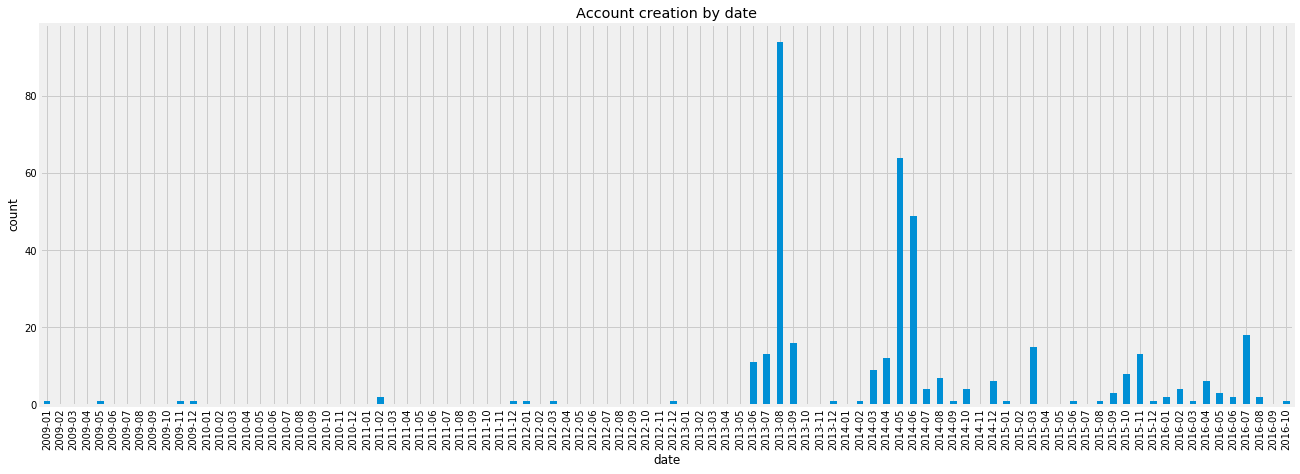

In [3]:
users_data['month'] = users_data['created_at'].dropna().dt.to_period('M')
months = users_data['month'].dropna().sort_values()
index = pd.PeriodIndex(start=months.iloc[0], end=months.iloc[-1])
users_data.groupby('month')['created_at'].count().reindex(index).plot.bar(figsize=(20,7), linewidth=1)
plt.title('Account creation by date')
plt.xlabel('date')
plt.ylabel('count')

## Časovna porazdelitev tweetov

Text(0,0.5,'count')

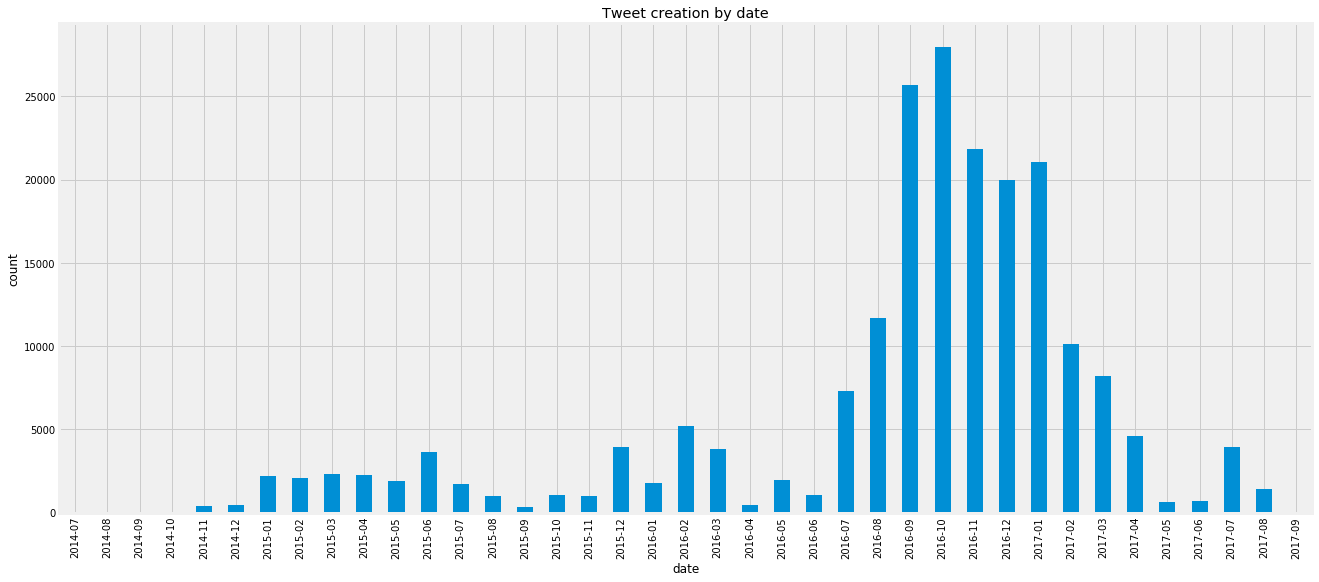

In [4]:
tweets_data['month'] = tweets_data['created_str'].dropna().dt.to_period('M')
months = tweets_data['month'].dropna().sort_values()
index = pd.PeriodIndex(start=months.iloc[0], end=months.iloc[-1])
tweets_data.groupby('month')['created_at'].count().reindex(index).plot.bar(figsize=(20,9), linewidth=1)
plt.title('Tweet creation by date')
plt.xlabel('date')
plt.ylabel('count')

## Hashtagi

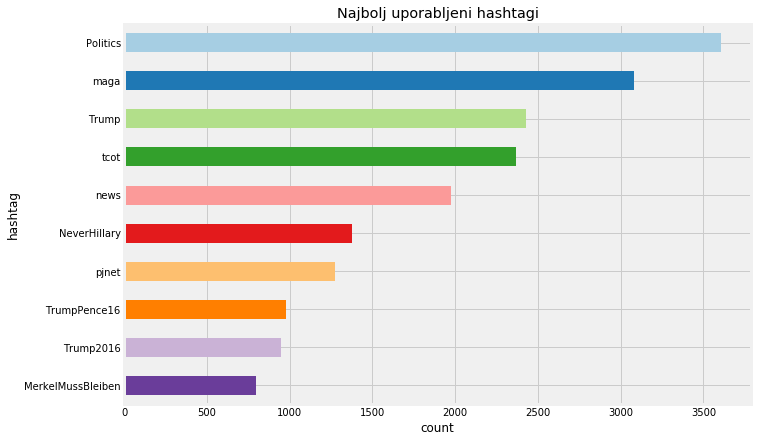

In [5]:
hashtags = np.array(tweets_data['hashtags'].apply(ast.literal_eval))
top10_hashtags = pd.Series(np.hstack(hashtags)).value_counts().nlargest(10)
top10_hashtags.T.plot(kind='barh', figsize=(10, 7), color=plt.cm.Paired(np.arange(len(top10_hashtags))))
plt.title('Najbolj uporabljeni hashtagi')
plt.xlabel('count')
plt.ylabel('hashtag')
plt.gca().invert_yaxis()

## Omenjeni uporabniki

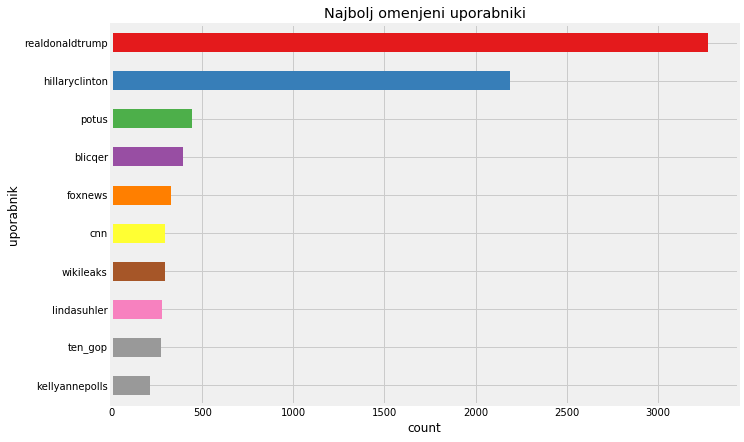

In [6]:
mentions = np.array(tweets_data['mentions'].apply(ast.literal_eval))
top10_mentions = pd.Series(np.hstack(mentions)).value_counts().nlargest(10)
top10_mentions.plot(kind='barh', figsize=(10, 7), color=plt.cm.Set1(np.arange(len(top10_mentions))))
plt.title('Najbolj omenjeni uporabniki')
plt.xlabel('count')
plt.ylabel('uporabnik')
plt.gca().invert_yaxis()